In [1]:
from ChromoGen import Conformations
from ChromoGen.data_utils import HiCDataset
from ChromoGen.model.Diffuser.training_utils import ConfigDataset
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import torch
import os
import sys
plt.style.use('../support/plot_style.txt')

2024-11-26 10:51:13.112415: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
save_dir = './maps_at_different_weights/'

coord_dir = Path('../../downloaded_data/conformations/ChromoGen/guidance_strength_comparison_for_S9/GM12878/')

mcool_fp = '../../outside_data/hic/GM12878_hg19.mcool'
dipc_fp = '../../downloaded_data/conformations/DipC/processed_data.h5'
region_length = 1_280_000

chroms_regions = [
    ('1',29020000),
    ('4',83760000),
    ('10',110860000),
    ('12',52640000)
]

guidance_strengths_phis_fractions = [
    (1.0,0.0),
    (2.0,2.0),
    (3.0,4.0),
    (4.0,6.0),
    (5.0,8.)
]

n_bootstrap_resamples = 25

In [3]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [4]:
exp_hic = HiCDataset(mcool_fp)

In [5]:
config_ds = ConfigDataset(
    dipc_fp,
    segment_length=64,
    remove_diagonal=False,
    batch_size=0,
    normalize_distances=False,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=None,
    replicates=None,
    shuffle=False,
    allow_overlap=True,
    two_channels=False,
    try_GPU=False,
    mean_dist_fp=None,
    mean_sq_dist_fp=None
)

In [6]:
torch.random.manual_seed(10); # for reproducibility

In [7]:
def load_coords(chrom,start_idx,cond_scale, rescaled_phi, coord_dir=coord_dir, config_ds=config_ds):
    fn = f'chrom_{chrom}/start_idx_{start_idx//1000}_cond_scale_{cond_scale}_rescaled_phi_{rescaled_phi}.pt'
    cgen = Conformations(coord_dir/fn,drop_invalid_conformations=True)
    dipc = Conformations(config_ds.fetch_specific_coords(chrom,start_idx)[-1])
    return cgen.double_().cpu_(), dipc.double_().cpu_()
    

## Plot

### Load coordinates/compute distances & choose a vmax to use everywhere in each row

In [8]:
dists = {}
for chrom,start in chroms_regions:
    if chrom not in dists:
        dists[chrom] = {}

    dists[chrom][start] = {}
    vmax = 0
    for cs, rp in guidance_strengths_phis_fractions:

        # load
        cgen_coords, dipc_coords = load_coords(chrom, start, cs, rp)

        # Get median distances
        cgen_dists = cgen_coords.distances.median
        dipc_dists = dipc_coords.distances.median

        # to nm
        cgen_dists._values*= 100
        dipc_dists._values*= 100

        # vmax
        vmax = max(vmax, cgen_dists.values.max(), dipc_dists.values.max())

        # preserve in the dict
        if cs not in dists[chrom][start]:
            dists[chrom][start][cs] = {}

        dists[chrom][start][cs][rp] = {
            'ChromoGen':cgen_dists,
            'Dip-C':dipc_dists
        }

    # preserve the computed vmax
    dists[chrom][start]['vmax'] = vmax
    
        
del cgen_coords, dipc_coords

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 46 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'E', 'G', 'H', 'I', 'a', 'c', 'colon', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 38, 39, 40, 42, 43, 44, 68, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 91, 92, 1894]
INFO:fontTool

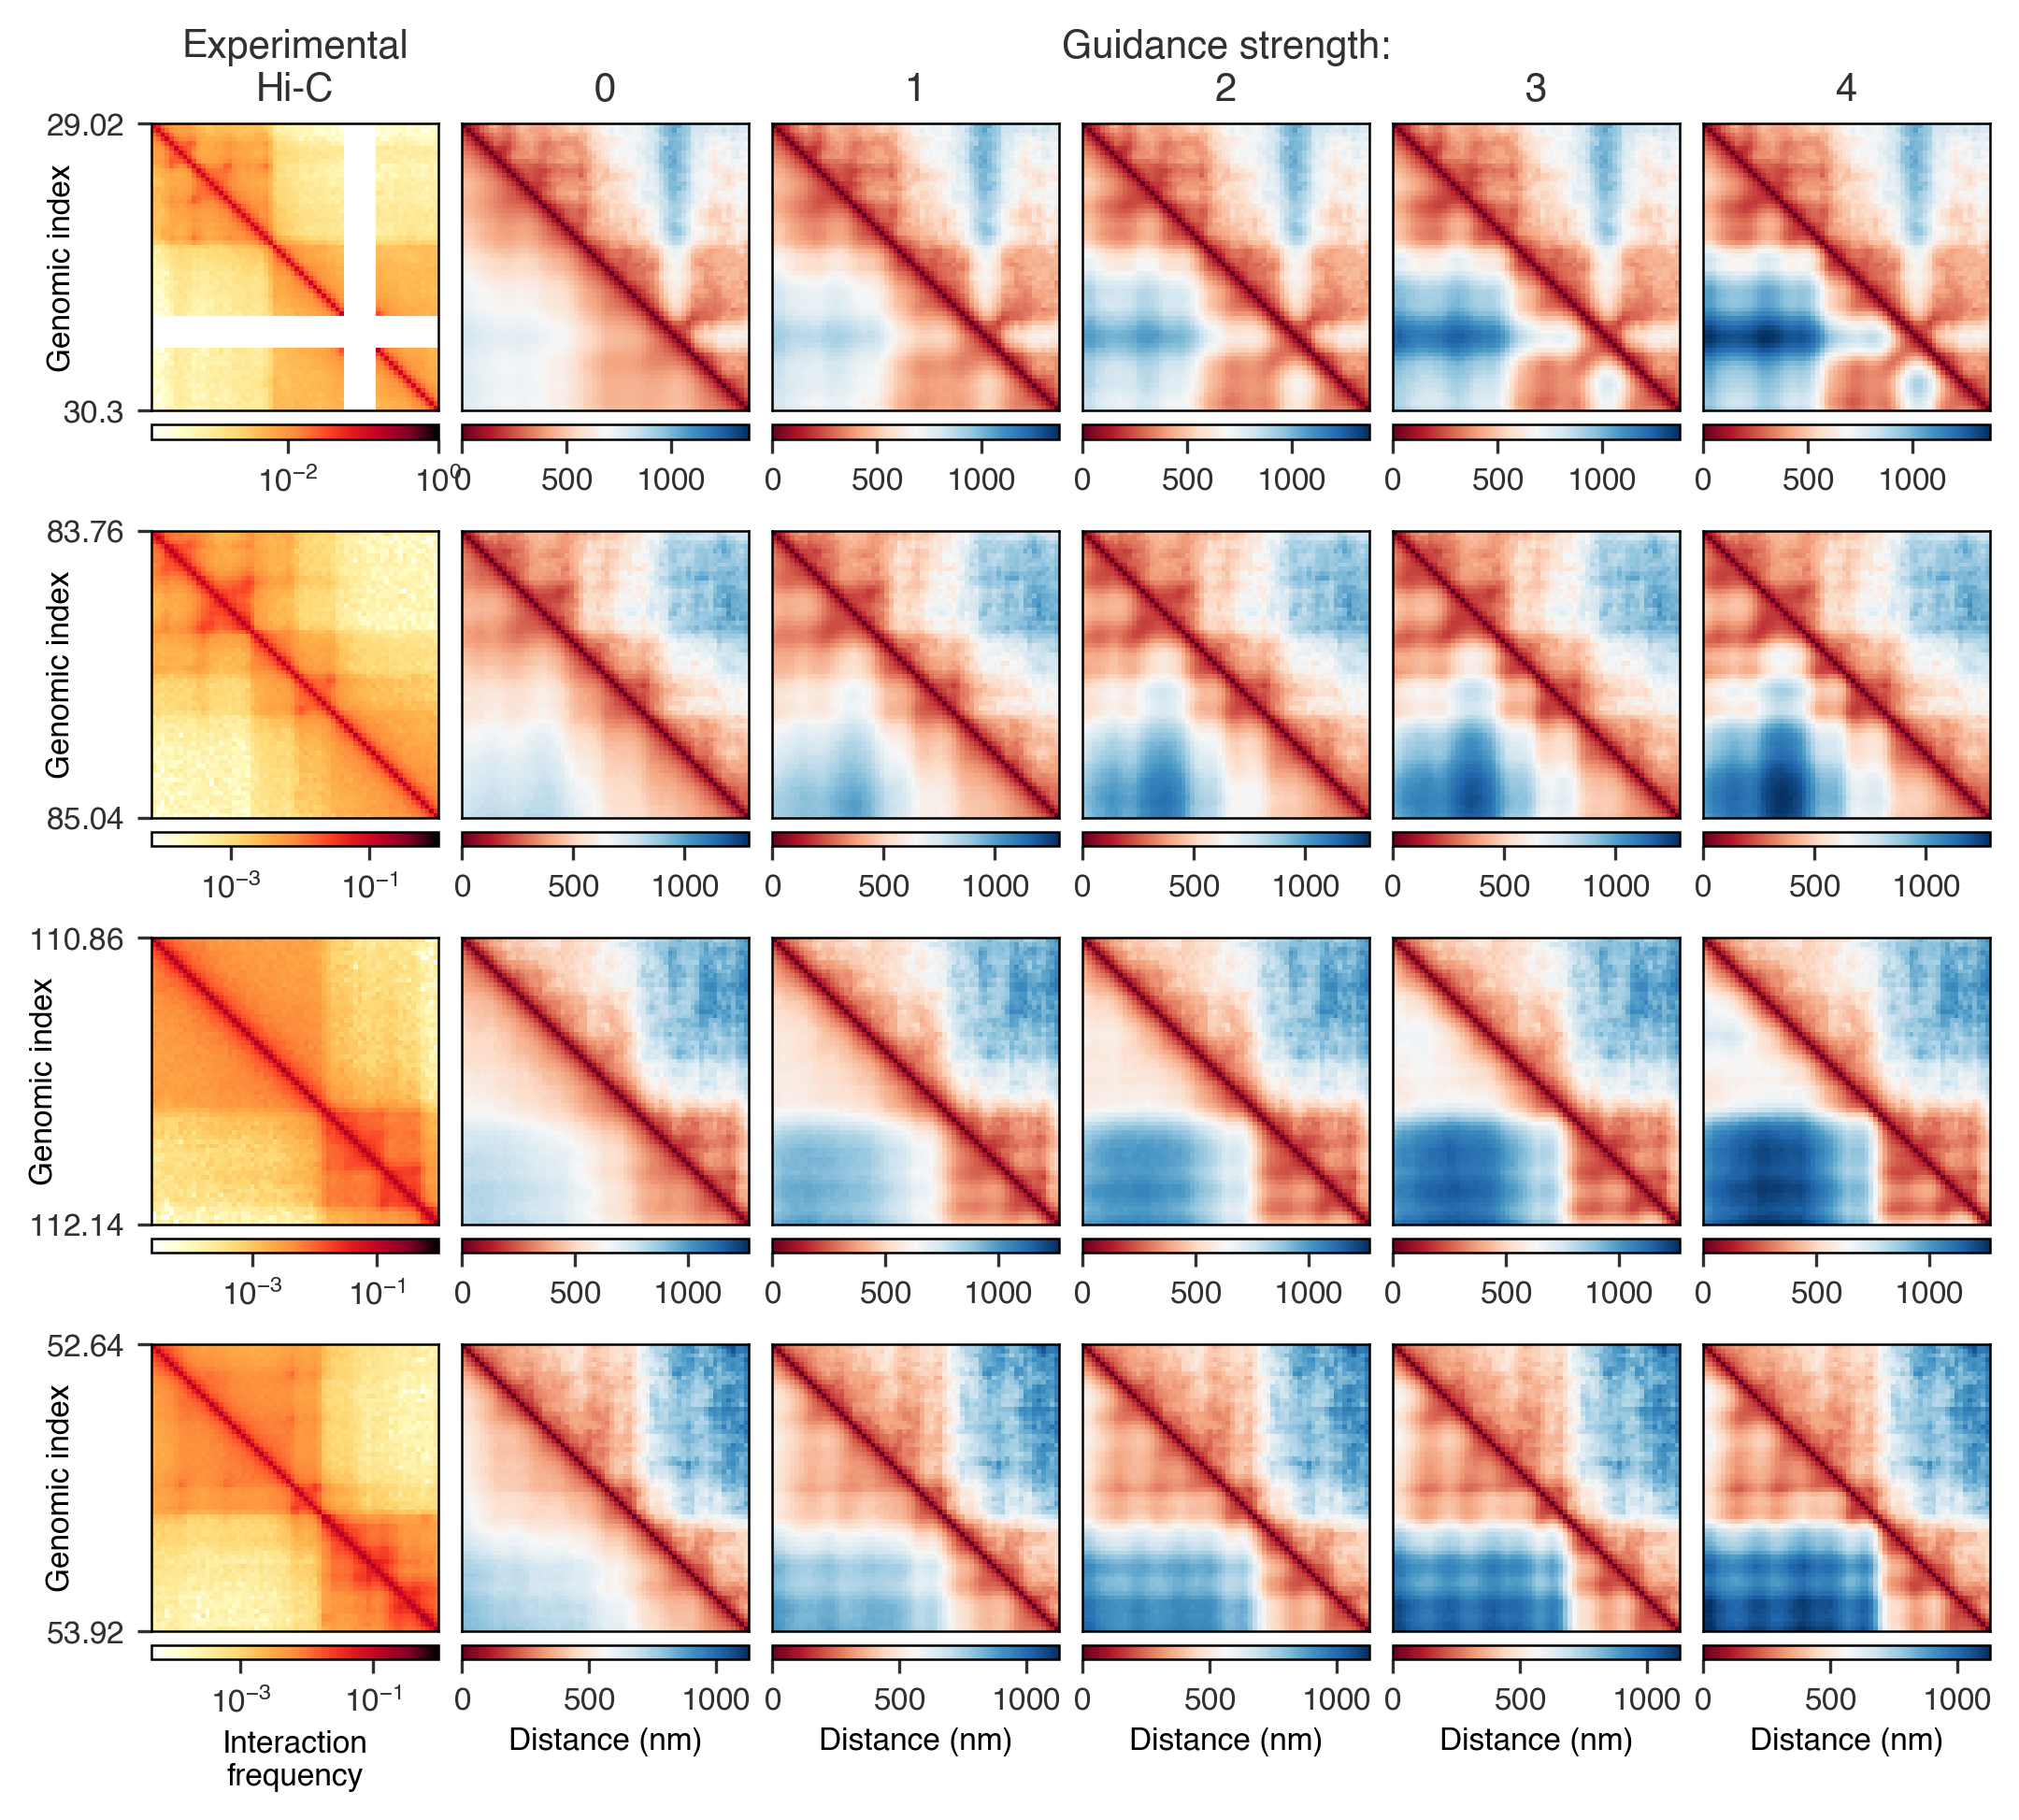

In [9]:
fig,axes = plt.subplots(nrows=4,ncols=6,figsize=(7.08,6.692*.9),layout='constrained')


for i,(chrom,start) in enumerate(chroms_regions):

    # Plot Hi-C
    ax = axes[i][0]
    *_,cbar=exp_hic.fetch(chrom,start,start + region_length).plot(fig=fig,ax=ax,cbar_orientation='horizontal')
    start1 = round(start/1e6,3)
    stop1 = round((start+region_length)/1e6,3)
    ax.set_yticks(ax.get_ylim(),labels=['$\\mathdefault{'f'{v}'+'}$' for v in [stop1,start1]])
    ax.set_ylabel('Genomic index',labelpad=-8)

    if i == 0:
        ax.set_title('Experimental\nHi-C')
    if i != 3:
        cbar.set_label('')
    else:
        cbar.set_label('Interaction\nfrequency')

    # Get Dip-C coordinates
    dipc_dists = Conformations(config_ds.fetch_specific_coords(chrom,start)[1]).distances.median.float()
    dipc_dists._values*= 100 
    
    for j,(cond_scale,rescaled_phi) in enumerate(guidance_strengths_phis_fractions):

        cgen_dists = dists[chrom][start][cond_scale][rescaled_phi]['ChromoGen']
        dipc_dists = dists[chrom][start][cond_scale][rescaled_phi]['Dip-C']
        vmax = dists[chrom][start]['vmax']
        
        ax = axes[i][j+1]
        
        *_,cbar = dipc_dists.plot_with(
            cgen_dists,
            fig=fig,
            ax=ax,
            cbar_orientation='horizontal',
            vmax=vmax
        )

        if i == 0:
            if j == 2:
                ax.set_title('Guidance strength:\n' + f'{int(cond_scale)-1}')
            else:
                ax.set_title(f'{int(cond_scale)-1}')
        if i == 3:
            cbar.set_label('Distance (nm)')
        else:
            cbar.set_label('')
        ax.set_ylabel('')
    
fig.savefig(save_dir + 'visualize_ws.pdf')